In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Load CSV
df = pd.read_csv("Filtered_CO2.csv")

# Drop qualitative columns
df_clean = df.drop(columns=['country'])

# Drop rows with all NaNs and report how many
initial_row_count = df_clean.shape[0]
df_clean = df_clean.dropna(how='all')
rows_dropped = initial_row_count - df_clean.shape[0]
print(f"Total rows dropped due to all-NaN values: {rows_dropped}")

# Drop columns with more than 50% missing values
missing_fraction = df_clean.isnull().mean()
dropped_columns = missing_fraction[missing_fraction > 0.5].index.tolist()
df_clean = df_clean.loc[:, missing_fraction <= 0.5]

print(f"Total columns dropped due to >50% missing values: {len(dropped_columns)}")
print("Dropped columns:")
for col in dropped_columns:
    print(f"- {col}")

# Impute remaining missing values using column means
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df_clean)

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Assign column names based on df_clean
clustered_data = pd.DataFrame(X_scaled, columns=df_clean.columns)

Total rows dropped due to all-NaN values: 0
Total columns dropped due to >50% missing values: 0
Dropped columns:


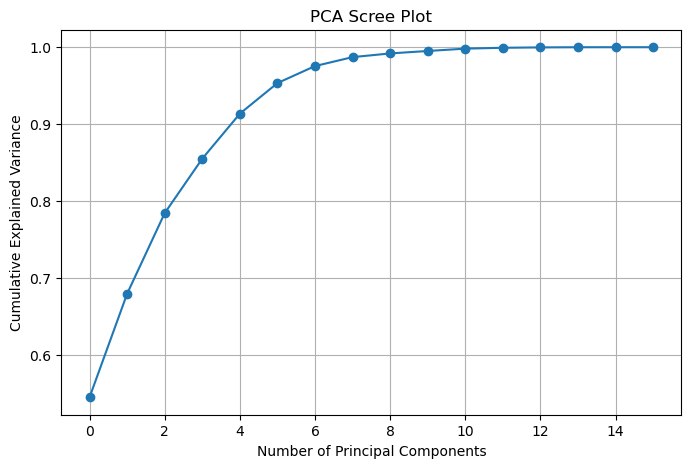

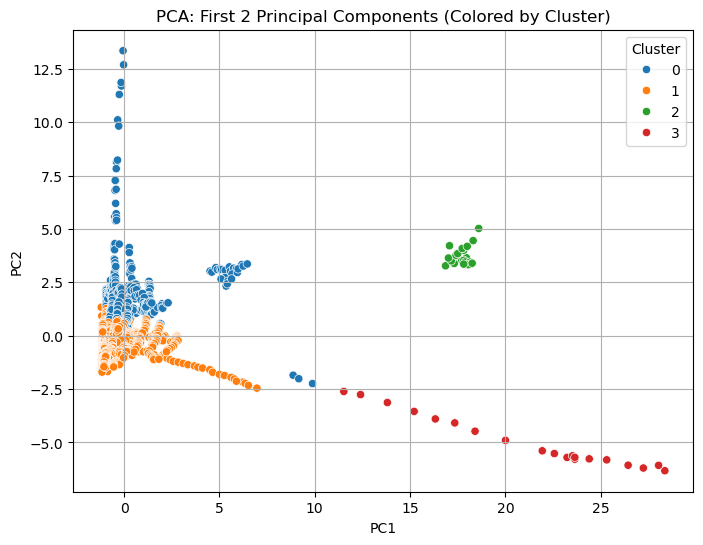

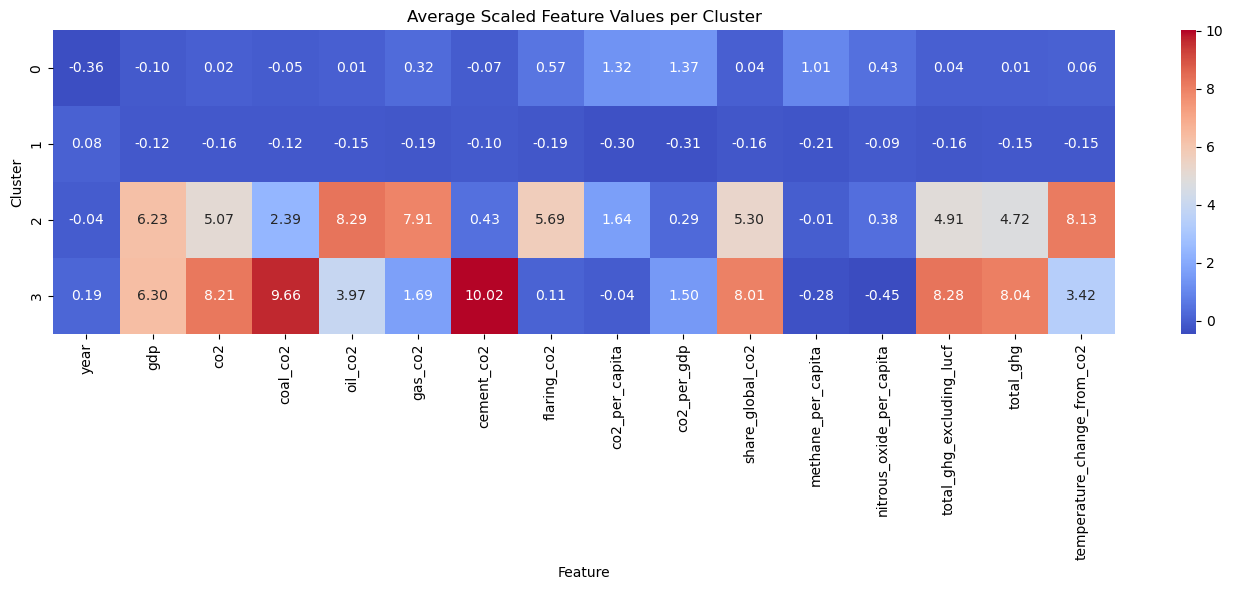


 Heatmap Interpretation: Each cell shows the average (scaled) value of a feature within a cluster. Warm colors (red) = high values, cool colors (blue) = low values. This helps understand what features define each cluster.

 Top 5 Features contributing to PC1 (economic scale & emissions impact):
co2                         0.333399
total_ghg_excluding_lucf    0.333330
share_global_co2            0.332167
total_ghg                   0.329812
gdp                         0.328031
Name: PC1, dtype: float64

 Top 5 Features contributing to PC2 (per-capita emissions):
co2_per_capita        0.565822
methane_per_capita    0.516609
co2_per_gdp           0.342607
flaring_co2           0.271636
cement_co2            0.221549
Name: PC2, dtype: float64

 Sample of labeled dataset with clusters:
       country  year  Cluster            Cluster_Label
0  Afghanistan  2000        1  Coal & Cement Economies
1  Afghanistan  2001        1  Coal & Cement Economies
2  Afghanistan  2002        1  Coal & Ceme

In [13]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Run PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 2. Run K-Means (k=4)
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# 3. Scree Plot
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.grid(True)
plt.show()

# 4. 2D PCA Visualization (colored by cluster)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='tab10')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: First 2 Principal Components (Colored by Cluster)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# 5. Cluster-wise feature averages
clustered_data = pd.DataFrame(X_scaled, columns=df_clean.columns)
clustered_data['Cluster'] = cluster_labels
cluster_feature_means = clustered_data.groupby('Cluster').mean().round(3)

# 6. Heatmap of cluster means
plt.figure(figsize=(14, 6))
sns.heatmap(cluster_feature_means, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Average Scaled Feature Values per Cluster")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

#  What the heatmap shows:
print("\n Heatmap Interpretation: Each cell shows the average (scaled) value of a feature within a cluster. Warm colors (red) = high values, cool colors (blue) = low values. This helps understand what features define each cluster.")

# 7. Top PCA contributors
pca_loadings = pd.DataFrame(pca.components_[:2], columns=df_clean.columns, index=['PC1', 'PC2']).T
top_pc1 = pca_loadings['PC1'].abs().sort_values(ascending=False).head(5)
top_pc2 = pca_loadings['PC2'].abs().sort_values(ascending=False).head(5)

print("\n Top 5 Features contributing to PC1 (economic scale & emissions impact):")
print(top_pc1)

print("\n Top 5 Features contributing to PC2 (per-capita emissions):")
print(top_pc2)

# 8. Add descriptive cluster labels
cluster_label_map = {
    0: "Low-Emission Trade-Oriented",
    1: "Coal & Cement Economies",
    2: "Legacy Oil & Gas Emitters",
    3: "High Per-Capita Emitters"
}

clustered_data['Cluster_Label'] = clustered_data['Cluster'].map(cluster_label_map)

# 9. Merge with country & year info for full view
final_clustered_df = pd.concat([df[['country', 'year']], clustered_data[['Cluster', 'Cluster_Label']]], axis=1)

# 10. Sample of labeled dataset
print("\n Sample of labeled dataset with clusters:")
print(final_clustered_df.head())

# 11. Table: Number of unique countries in each cluster
country_cluster_summary = final_clustered_df.groupby('Cluster_Label')['country'].nunique().sort_values(ascending=False)
print("\n Unique Countries per Cluster:")
print(country_cluster_summary)

In [14]:
# Step 1: Get top 2 countries per cluster based on frequency
top_country_examples = (
    final_clustered_df.groupby(['Cluster', 'country'])
    .size()
    .reset_index(name='count')
    .sort_values(['Cluster', 'count'], ascending=[True, False])
    .groupby('Cluster')
    .head(5)
)

# Step 2: Combine the top countries into comma-separated strings
country_examples = (
    top_country_examples.groupby('Cluster')['country']
    .apply(lambda x: ", ".join(x))
    .reset_index(name='Countries (examples)')
)

# Step 3: Define cluster labels and key traits
cluster_summary = pd.DataFrame({
    'Cluster': [0, 1, 2, 3],
    'Label': [
        "Low-Emission Trade-Oriented",
        "Coal & Cement Economies",
        "Legacy Oil & Gas Emitters",
        "High Per-Capita Emitters"
    ],
    'Key Traits': [
        "Low GHG, high trade CO₂/unit energy",
        "High cement/coal CO₂, modest GDP",
        "High oil/gas CO₂, stable trends",
        "High CO₂/Capita, high global share"
    ]
})

# Step 4: Merge into final summary table
cluster_table = pd.merge(cluster_summary, country_examples, on='Cluster')

# Step 5: Display the table
display(cluster_table)

,Cluster,Label,Key Traits,Countries (examples)
0,0,Low-Emission Trade-Oriented,"Low GHG, high trade CO₂/unit energy","Australia, Canada, Iran, Kazakhstan, Kuwait"
1,1,Coal & Cement Economies,"High cement/coal CO₂, modest GDP","Afghanistan, Albania, Algeria, Argentina, Armenia"
2,2,Legacy Oil & Gas Emitters,"High oil/gas CO₂, stable trends",United States
3,3,High Per-Capita Emitters,"High CO₂/Capita, high global share",China


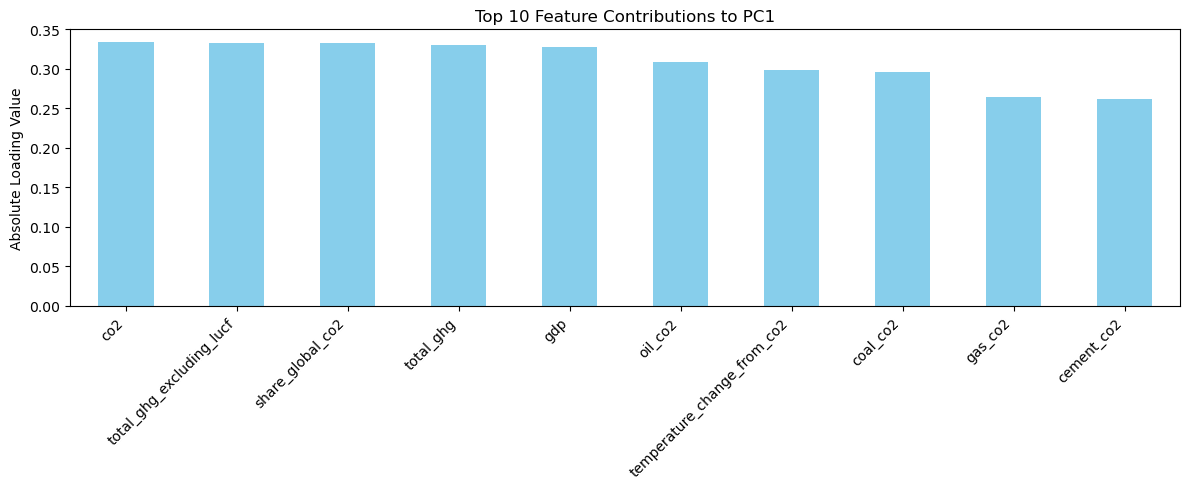

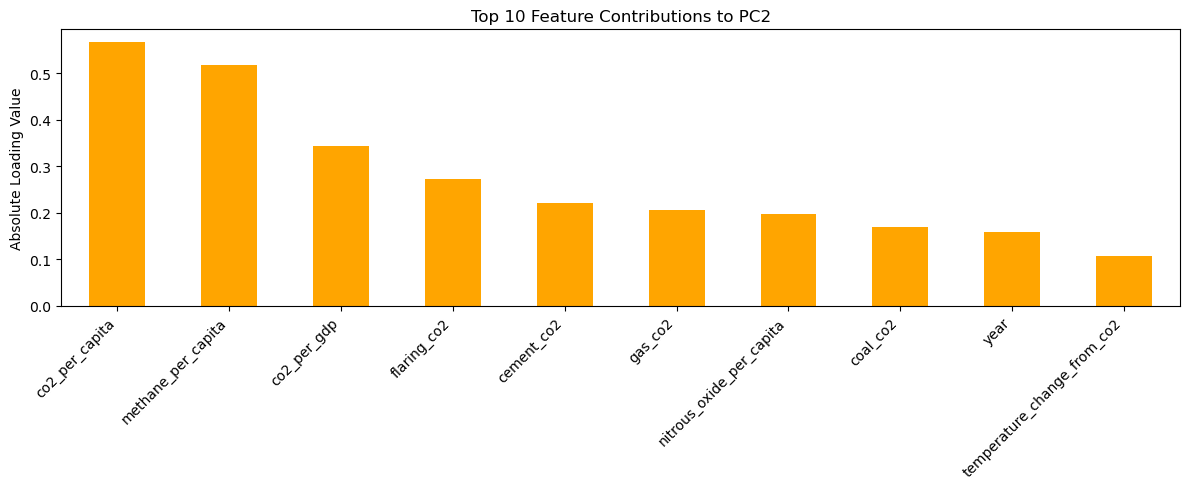

In [15]:
pca_loadings_df = pd.DataFrame(pca.components_[:2], index=['PC1', 'PC2'], columns=df_clean.columns).T

# PC1
plt.figure(figsize=(12, 5))
pca_loadings_df['PC1'].abs().sort_values(ascending=False).head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Feature Contributions to PC1")
plt.ylabel("Absolute Loading Value")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# PC2
plt.figure(figsize=(12, 5))
pca_loadings_df['PC2'].abs().sort_values(ascending=False).head(10).plot(kind='bar', color='orange')
plt.title("Top 10 Feature Contributions to PC2")
plt.ylabel("Absolute Loading Value")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

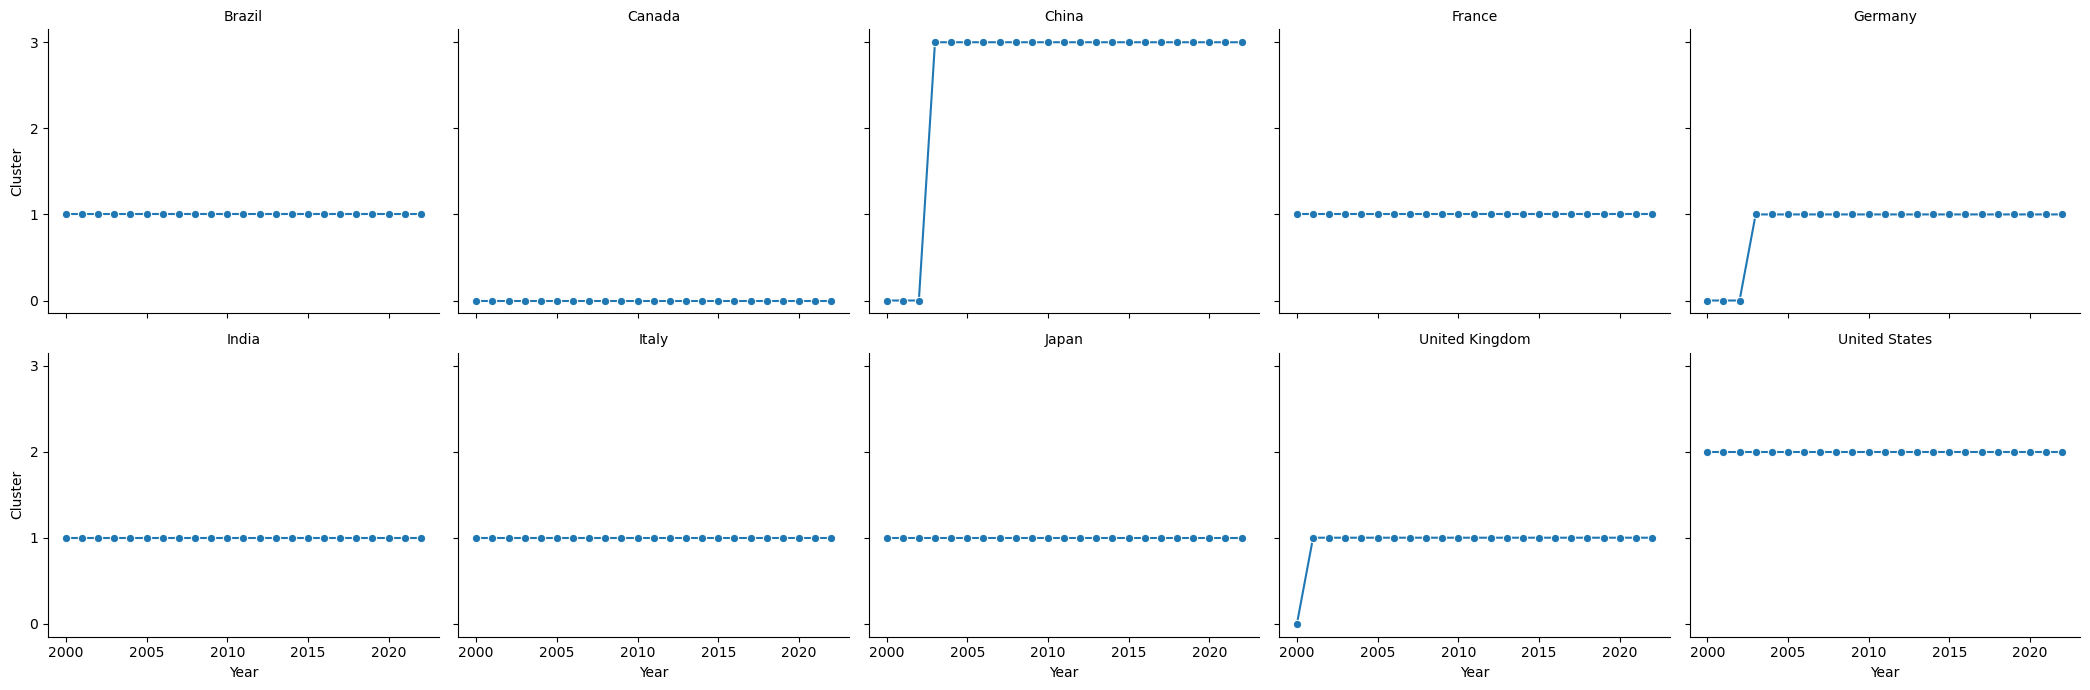

In [16]:
# Top 10 GDP countries from the image
selected_countries = [
    'United States', 'China', 'Germany', 'India', 'Japan',
    'United Kingdom', 'France', 'Italy', 'Canada', 'Brazil'
]

# Filter from final labeled dataset
timeline_df = final_clustered_df[final_clustered_df['country'].isin(selected_countries)]

g = sns.FacetGrid(timeline_df, col='country', col_wrap=5, height=3.5, aspect=1.2)
g.map_dataframe(sns.lineplot, x='year', y='Cluster', marker='o')
g.set_titles("{col_name}")
g.set_axis_labels("Year", "Cluster")
g.set(yticks=[0, 1, 2, 3])
plt.tight_layout()
plt.show()